In [36]:
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import PIL.Image as pil_image
from torch import nn
from torchvision import transforms

In [37]:
# RGB转换到YCbCr空间
def rgb_to_ycbcr(image):
    y = 16. + (64.738 * image[:, :, 0] + 129.057 * image[:, :, 1] + 25.064 * image[:, :, 2]) / 256.
    cb = 128. + (-37.945 * image[:, :, 0] - 74.494 * image[:, :, 1] + 112.439 * image[:, :, 2]) / 256.
    cr = 128. + (112.439 * image[:, :, 0] - 94.154 * image[:, :, 1] - 18.285 * image[:, :, 2]) / 256.
    return np.array([y, cb, cr]).transpose([1, 2, 0])


# YCbCr空间转换到RGB
def ycbcr_to_rgb(image):
    r = 298.082 * image[:, :, 0] / 256. + 408.583 * image[:, :, 2] / 256. - 222.921
    g = 298.082 * image[:, :, 0] / 256. - 100.291 * image[:, :, 1] / 256. - 208.120 * image[:, :, 2] / 256. + 135.576
    b = 298.082 * image[:, :, 0] / 256. + 516.412 * image[:, :, 1] / 256. - 276.836
    return np.array([r, g, b]).transpose([1, 2, 0])

# 计算psnr
def get_psnr(image1, image2):
    image1 = transforms.ToTensor()(image1).unsqueeze(0)
    image2 = transforms.ToTensor()(image2).unsqueeze(0)
    return 10. * torch.log10(1. / torch.mean((image1 - image2) ** 2))

In [38]:
# 定义SRCNN
class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [39]:
scale = 4  # 下采样倍数
weights_file = "BLAH_BLAH/srcnn_x{}.pth".format(scale)  # 预训练权重
image_file = "data/butterfly_GT.bmp"  # 测试图片

cudnn.benchmark = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SRCNN().to(device)

# 导入预训练权重
state_dict = model.state_dict()
for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)

model.eval()
print(model)

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)


PSNR: 31.38


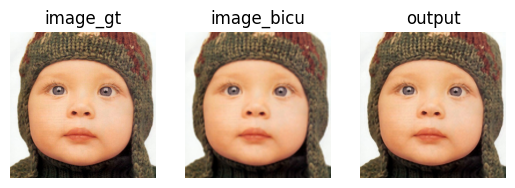

PSNR: 29.46


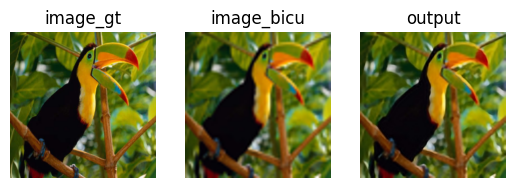

PSNR: 23.73


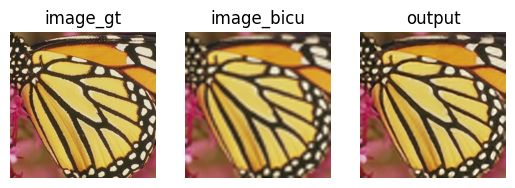

PSNR: 29.40


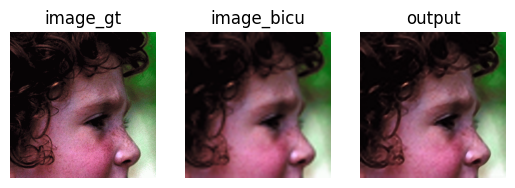

PSNR: 26.98


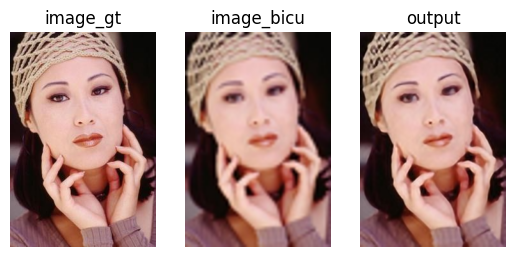

In [40]:
import matplotlib.pyplot as plt
from natsort import natsorted
import os

gt_dir = f"GTmod12"

# 按照文件名的正常语序进行排序
file_names = natsorted(os.listdir(gt_dir))
# Get the number of test image files.
file_num = len(file_names)

for i in range(file_num):

    image_file = os.path.join(gt_dir, file_names[i])
    # 原图像
    image_gt = pil_image.open(image_file).convert('RGB')

    # BICUBIC下采样，作为测试图像并保存
    image_width = (image_gt.width // scale) * scale
    image_height = (image_gt.height // scale) * scale
    image = image_gt.resize((image_width, image_height), resample=pil_image.BICUBIC)
    image = image.resize((image.width // scale, image.height // scale), resample=pil_image.BICUBIC)
    image_bi = image.resize((image.width * scale, image.height * scale), resample=pil_image.BICUBIC)
    image_bi.save(image_file.replace('.', '_bicubic_x{}.'.format(scale)))
    image_bicu = np.array(image_bi).astype(np.float32)

    # RGB转换到YCbCr空间
    ycbcr = rgb_to_ycbcr(image_bicu)
    y = ycbcr[..., 0]/255.
    y = torch.from_numpy(y).unsqueeze(0).unsqueeze(0).to(device)

    #预测结果
    with torch.no_grad():
        preds = model(y).clamp(0.0, 1.0)  # 输出归一化

    preds = preds.mul(255.0).cpu().numpy().squeeze(0).squeeze(0)

    # 保存结果，YCbCr空间转换到RGB
    output = np.array([preds, ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
    output = np.clip(ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)
    output = pil_image.fromarray(output)
    output.save(image_file.replace('.', '_srcnn_x{}.'.format(scale)))

    # 计算psnr
    psnr = get_psnr(image_gt, output)
    print('PSNR: {:.2f}'.format(psnr))

    plt.subplot(1, 3, 1)
    plt.imshow(np.array(image_gt))
    plt.title('image_gt')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(image_bi)
    plt.title('image_bicu')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(np.array(output))
    plt.title('output')
    plt.axis('off')

    plt.show()